# Exploring the Impacts of Architecture and Scale on GNN Performance on Relational Data
By: Joseph Guman, Atindra Jha, and Christopher Pondoc

## Introduction
Welcome back to Relbench! In this tutorial, we'll dive a bit deeper into the benchmark + Relational Deep Learning and explore several choices around architecture, scale, and generalizability. In particular, we'll look to answer the following questions:

1. Can we train our Relational Deep Learning on one entity classification task and expect strong zero-shot performance on another entity classification task? What happens if we finetune the model?
2. How does our choice of using embedding models to generate expressive node features impact our performance on node classification tasks?
3. How can we alter and/or extend the architecture of our existing Relational Deep Learning model to improve performance on different tasks?

This notebook already assumes you've looked through the tutorials on [loading in data](https://github.com/snap-stanford/relbench/blob/main/tutorials/load_data.ipynb) and [training a model](https://github.com/snap-stanford/relbench/blob/main/tutorials/train_model.ipynb), as our walkthrough uses those guides as a launchpad to explore deeper questions. If you haven't had a chance to look through those notebooks, we suggest starting there first.

With all that being said, let's get started!

## Question 0: Why Relational Deep Learning
Before getting started, let's motivate the use of Relational Deep Learning by defining a non-GNN baseline to compare against. One of the main issues with older methods -- such as tabular methods or even just using standard statistical ML algorithms -- is that they either only work on one table or require lots of heavy feature engineering to reap the benefits of GNNs. On the other hand, Relational Deep Learning allows us to learn directly on relational data without feature engineering.

For our baseline, let's use a classical statiscal model. In particular, let's use [LightGBM](https://lightgbm.readthedocs.io/en/stable/), which is a gradient boosting framework that uses tree-based learning algorithms.

In [6]:
# Run LightGBM baseline
from src.models.baseline import train_model

train_metrics, val_metrics, test_metrics = train_model("rel-avito", "user-visits")

# Print corresponding statistics
print(f"Train: {train_metrics}")
print(f"Val: {val_metrics}")
print(f"Test: {test_metrics}")

100%|████████████████████████████████████████| 364M/364M [00:00<00:00, 366GB/s]
Unzipping contents of '/home/atindrajha/.cache/relbench/rel-avito/db.zip' to '/home/atindrajha/.cache/relbench/rel-avito/.'
100%|████████████████████████████████████████| 696k/696k [00:00<00:00, 953MB/s]
Unzipping contents of '/home/atindrajha/.cache/relbench/rel-avito/tasks/user-visits.zip' to '/home/atindrajha/.cache/relbench/rel-avito/tasks/.'


Loading Database object from /home/atindrajha/.cache/relbench/rel-avito/db...
Done in 4.46 seconds.


[I 2024-12-10 05:33:58,929] A new study created in memory with name: no-name-46e67361-212a-440b-81ac-11b70bfb7337
/home/atindrajha/miniconda3/envs/relben/lib/python3.10/site-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
[I 2024-12-10 05:33:59,809] Trial 0 finished with value: 0.5316566155517655 and parameters: {'max_depth': 10, 'learning_rate': 0.07591286446746079, 'num_leaves': 177, 'subsample': 0.20735271420006968, 'colsample_bytree': 0.4603272246879903, 'lambda_l1': 5.062944847723688, 'lambda_l2': 3.0275437288710756e-05, 'min_data_in_leaf': 54}. Best is trial 0 with value: 0.5316566155517655.
/home/atindrajha/miniconda3/envs/relben/lib/python3.10/site-packages/lightgbm/engine.py:186: LGBMDeprecat

Train: {'average_precision': np.float64(0.9303941469423928), 'accuracy': 0.9071, 'f1': np.float64(0.9512872948455771), 'roc_auc': np.float64(0.594062785875664)}
Val: {'average_precision': np.float64(0.9129439438321935), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.5382835341152871)}
Test: {'average_precision': np.float64(0.8612920046166976), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.5308820751280316)}


Great! It looks like just by taking together all of raw tables and merging them together, we're able to achieve reasonable baseline performance. Let's see if we can do better without having to merge together all of the tables, though, with Relational Deep Learning!

## Question 1: Can we generalize?
Let's take a look at our first question, which involves looking at whether our Relational Deep Learning model can generalize to other tasks with/without finetuning.

Let's first start by looking setting up Relbench. As with the other tutorials, we're taking a look at the `rel-f1` dataset and focusing on node classification tasks. We'll begin by training a model on the `driver-dnf` task, which predicts whether a driver will not finish a race in the next month.

In [7]:
from src.tasks.tasks import initialize_task, db_to_graph
import torch
from torch.nn import BCEWithLogitsLoss
from torch_geometric.seed import seed_everything

# Set up dataset and task, define metrics and loss
dataset, task, train_table, val_table, test_table = initialize_task(
    "rel-avito", "user-visits"
)
loss_fn = BCEWithLogitsLoss()

# Set up device
seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We can then preprocess all of our Relbench data.

In [11]:
import os
from relbench.modeling.graph import make_pkey_fkey_graph
from torch_frame.config.text_embedder import TextEmbedderConfig
from src.embeddings.glove import GloveTextEmbedding

# Preprocess the database data and set up our text embedder
db, col_to_stype_dict = db_to_graph(dataset)
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=GloveTextEmbedding(device=device), batch_size=128
)

# Load in data used to train model
root_dir = "./data"
data, col_stats_dict = make_pkey_fkey_graph(
    db,
    col_to_stype_dict=col_to_stype_dict,
    text_embedder_cfg=text_embedder_cfg,
    cache_dir=os.path.join(root_dir, f"rel-avito_materialized_cache"),
)

Embedding raw data in mini-batch: 100%|██████████| 46567/46567 [02:55<00:00, 264.73it/s]


Next, let's load in the data and have our model set up.

In [12]:
from src.models.loader import get_loader
from src.models.rdl.graph_sage import RDLModel

# Set up data loader and model
loader_dict, entity_table = get_loader(train_table, val_table, test_table, task, data)
model = RDLModel(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)

# if you try out different RelBench tasks you will need to change these
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
epochs = 10

Finalize, let's initialize our training run, and evaluate our model!

In [13]:
from src.models.training import eval_model, training_run

# Get model after a training run
state_dict = training_run(
    model, device, optimizer, task, loader_dict, val_table, loss_fn, entity_table
)
model.load_state_dict(state_dict)

# Evaluate on val and test set
eval_model(model, loader_dict, "val", task, device, val_table)
eval_model(model, loader_dict, "test", task, device, None)

100%|██████████| 98/98 [00:11<00:00,  8.58it/s]


Epoch: 01, Train loss: 0.3011522589969635, Val metrics: {'average_precision': np.float64(0.9480965701898839), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6763673956893048)}


100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Epoch: 02, Train loss: 0.29577107947349546, Val metrics: {'average_precision': np.float64(0.9507069215186927), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6848994110474864)}


100%|██████████| 98/98 [00:11<00:00,  8.60it/s]


Epoch: 03, Train loss: 0.29435662059783935, Val metrics: {'average_precision': np.float64(0.9523664401575884), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6935351849681899)}


100%|██████████| 98/98 [00:12<00:00,  7.85it/s]


Epoch: 04, Train loss: 0.293416542263031, Val metrics: {'average_precision': np.float64(0.9510705709978006), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.690763617078237)}


100%|██████████| 98/98 [00:11<00:00,  8.62it/s]


Epoch: 05, Train loss: 0.2931678270149231, Val metrics: {'average_precision': np.float64(0.9534016415030016), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6953856874414097)}


100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Epoch: 06, Train loss: 0.29220681492805484, Val metrics: {'average_precision': np.float64(0.9529980298484715), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6943184437509652)}


100%|██████████| 98/98 [00:11<00:00,  8.60it/s]


Epoch: 07, Train loss: 0.2920016995477676, Val metrics: {'average_precision': np.float64(0.9527587514381176), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.693961385658498)}


100%|██████████| 98/98 [00:11<00:00,  8.57it/s]


Epoch: 08, Train loss: 0.29175365707874296, Val metrics: {'average_precision': np.float64(0.9516926326296676), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6917537868078731)}


100%|██████████| 98/98 [00:11<00:00,  8.57it/s]


Epoch: 09, Train loss: 0.2915800398826599, Val metrics: {'average_precision': np.float64(0.9507000053565878), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6887607788371277)}


100%|██████████| 98/98 [00:11<00:00,  8.53it/s]


Epoch: 10, Train loss: 0.2910608741283417, Val metrics: {'average_precision': np.float64(0.9514329364479555), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6904262246822025)}
Best val metrics: {'average_precision': np.float64(0.9534335302642337), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6954176808878451)}
Best test metrics: {'average_precision': np.float64(0.9160877410269225), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6636236701389361)}


{'average_precision': np.float64(0.9160877410269225),
 'accuracy': 0.8505909380276232,
 'f1': np.float64(0.9192641340113671),
 'roc_auc': np.float64(0.6636236701389361)}

As we can see, we are able to roughly replicate the results from the [core Relbench paper](https://huggingface.co/spaces/relbench/leaderboard). However, do the results generalize? To do so, let's load in the data for the other entity classification task within `rel-f1` -- `driver-top3` -- and see how we do. 

In [14]:
# Logging Results
part1_top3_labels = ["Trained on User Visits, Zero-Shot on User Clicks"]
part1_top3_scores = []

# Reuse functions to set up `driver-top3 task`
dataset, task, train_table, val_table, test_table = initialize_task(
    "rel-avito", "user-clicks"
)
db, col_to_stype_dict = db_to_graph(dataset)
data, col_stats_dict = make_pkey_fkey_graph(
    db,
    col_to_stype_dict=col_to_stype_dict,
    text_embedder_cfg=text_embedder_cfg,
    cache_dir=os.path.join(root_dir, f"rel-avito_materialized_cache"),
)

loader_dict, entity_table = get_loader(train_table, val_table, test_table, task, data)
model = RDLModel(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)
model.load_state_dict(state_dict)

test_metrics = eval_model(model, loader_dict, "test", task, device, None)
part1_top3_scores.append(test_metrics["roc_auc"])

100%|████████████████████████████████████████| 603k/603k [00:00<00:00, 810MB/s]
Unzipping contents of '/home/atindrajha/.cache/relbench/rel-avito/tasks/user-clicks.zip' to '/home/atindrajha/.cache/relbench/rel-avito/tasks/.'
/home/atindrajha/miniconda3/envs/relben/lib/python3.10/site-packages/torch_frame/utils/io.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

Best test metrics: {'average_precision': np.float64(0.029305983113059285), 'accuracy': 0.015417951495957996, 'f1': np.float64(0.03036769533814839), 'roc_auc': np.float64(0.6474129983208194)}


Unfortunately, trying out our model zero-shot does not yield amazing results. However, what happens if we use this model as a starting point for finetuning on the task? Let's experiment on fine-tuning this model with fewer epochs on the `driver-top3` task and checking its performance.

In [15]:
# Logging Results
part1_top3_labels.append("Trained on User Visits, Finetuned on User Clicks")

# Get model after a training run
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
state_dict = training_run(
    model,
    device,
    optimizer,
    task,
    loader_dict,
    val_table,
    loss_fn,
    entity_table,
    epochs=5,
    state_dict=state_dict,
)
model.load_state_dict(state_dict)

# Evaluate on val and test set
eval_model(model, loader_dict, "val", task, device, val_table)
test_metrics = eval_model(model, loader_dict, "test", task, device, None)
part1_top3_scores.append(test_metrics["roc_auc"])

100%|██████████| 117/117 [00:14<00:00,  7.90it/s]


Epoch: 01, Train loss: 0.2334034409572375, Val metrics: {'average_precision': np.float64(0.053769921785753155), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6157990018592817)}


100%|██████████| 117/117 [00:14<00:00,  8.00it/s]


Epoch: 02, Train loss: 0.15894010762433758, Val metrics: {'average_precision': np.float64(0.05817973345498606), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6258583662095412)}


100%|██████████| 117/117 [00:14<00:00,  7.96it/s]


Epoch: 03, Train loss: 0.1583660256275356, Val metrics: {'average_precision': np.float64(0.06367939846668577), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.63169760106027)}


100%|██████████| 117/117 [00:14<00:00,  8.07it/s]


Epoch: 04, Train loss: 0.15812988054897917, Val metrics: {'average_precision': np.float64(0.06604753750499472), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6332116908167508)}


100%|██████████| 117/117 [00:15<00:00,  7.54it/s]


Epoch: 05, Train loss: 0.15786859386703594, Val metrics: {'average_precision': np.float64(0.06813952641422835), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6369930403361025)}
Best val metrics: {'average_precision': np.float64(0.06813073216804698), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6367829434708738)}
Best test metrics: {'average_precision': np.float64(0.03570655066222605), 'accuracy': 0.984582048504042, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6738423177494406)}


Nice! It looks like after we finetune even after just one epoch. we're able to practically replicate the Relbench results. Finally, let's compare this approach to simply training on the task from scratch.

100%|██████████| 117/117 [00:14<00:00,  7.95it/s]


Epoch: 01, Train loss: 0.16988240671786625, Val metrics: {'average_precision': np.float64(0.06386555502630002), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6169798197987562)}


100%|██████████| 117/117 [00:14<00:00,  7.97it/s]


Epoch: 02, Train loss: 0.1597294359416763, Val metrics: {'average_precision': np.float64(0.06793630576856795), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6316647960011323)}


100%|██████████| 117/117 [00:14<00:00,  8.01it/s]


Epoch: 03, Train loss: 0.15942406274522916, Val metrics: {'average_precision': np.float64(0.0673321475102239), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6213280499346198)}


100%|██████████| 117/117 [00:14<00:00,  7.95it/s]


Epoch: 04, Train loss: 0.15922961761336532, Val metrics: {'average_precision': np.float64(0.07046906893837794), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6244504742120711)}


100%|██████████| 117/117 [00:14<00:00,  8.01it/s]


Epoch: 05, Train loss: 0.15908782976777344, Val metrics: {'average_precision': np.float64(0.0699842271771561), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6314103022991125)}


100%|██████████| 117/117 [00:14<00:00,  8.03it/s]


Epoch: 06, Train loss: 0.15810887773998106, Val metrics: {'average_precision': np.float64(0.06470453092676201), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6384584971670747)}


100%|██████████| 117/117 [00:14<00:00,  7.92it/s]


Epoch: 07, Train loss: 0.15860653774133662, Val metrics: {'average_precision': np.float64(0.06941605675293815), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6434413196631358)}


100%|██████████| 117/117 [00:14<00:00,  8.03it/s]


Epoch: 08, Train loss: 0.1577732623942778, Val metrics: {'average_precision': np.float64(0.06863579015572402), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6373435848869491)}


100%|██████████| 117/117 [00:14<00:00,  8.00it/s]


Epoch: 09, Train loss: 0.1576428290129582, Val metrics: {'average_precision': np.float64(0.06975480247249642), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6373547826098378)}


100%|██████████| 117/117 [00:14<00:00,  7.99it/s]


Epoch: 10, Train loss: 0.15752264101231306, Val metrics: {'average_precision': np.float64(0.07203948118081588), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6414129556011929)}
Best val metrics: {'average_precision': np.float64(0.06905970323751082), 'accuracy': 0.9648302884388424, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6437679253870439)}
Best test metrics: {'average_precision': np.float64(0.03566880492185055), 'accuracy': 0.984582048504042, 'f1': np.float64(0.0), 'roc_auc': np.float64(0.6626739518848458)}


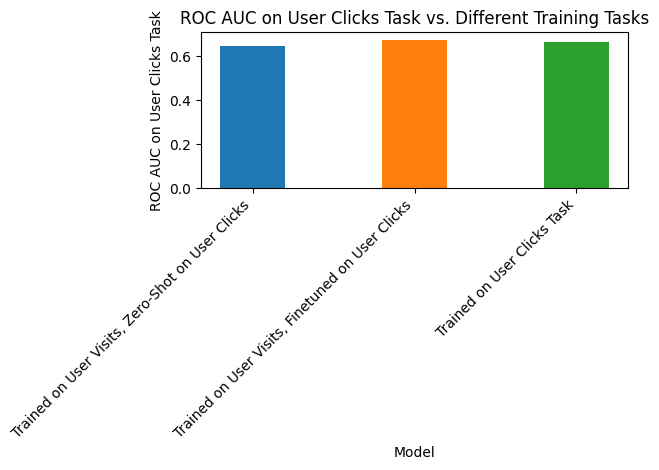

In [16]:
# Logging Results
from src.models.viz import create_bar_graph
part1_top3_labels.append("Trained on User Clicks Task")

# Define a new model, don't load in old weights.
base_model = RDLModel(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)
base_optimizer = torch.optim.Adam(base_model.parameters(), lr=0.005)
base_state_dict = training_run(
    base_model,
    device,
    base_optimizer,
    task,
    loader_dict,
    val_table,
    loss_fn,
    entity_table,
    epochs=10,
)
base_model.load_state_dict(base_state_dict)

# Evaluate on val and test set
eval_model(base_model, loader_dict, "val", task, device, val_table)
test_metrics = eval_model(base_model, loader_dict, "test", task, device, None)
part1_top3_scores.append(test_metrics["roc_auc"])

# Finally, graph all of the results
create_bar_graph(part1_top3_labels, part1_top3_scores, title='ROC AUC on User Clicks Task vs. Different Training Tasks', x_label="Model", y_label="ROC AUC on User Clicks Task")

Ultimately, we don't see much of a difference from starting from random weights to using a model pre-initialized from another entity classification task.

### Challenge
Does this trend necessarily work on larger and more diverse datasets? Depending on your compute availability, try out using different datasets, like `rel-amazon`, as well as across different types of tasks!

## Question 2: Different expressiveness of node features?
Next, let's take a look at using different embedding models for node features.

The embedding models are used to help turn the tabular data into usable node features. In the Relbench tutorial, the team uses GloVe embeddings, but the paper also mentions utilizing BERT-style embeddings. In traditional NLP, BERT embeddings are much more popular given that they are contextual -- the vector representation depends on the surrounding words, compared to static embeddings used by GloVe -- and can handle words outside of their vocabulary. In addition, their embedding size is $768$ compared to GloVe's $300$, which introduces an opportunity for more expressiveness.

As an investigation, let's switch out our GloVe embedding model with BERT and retrain a new model from scratch on the `driver-dnf` task.

In [17]:
from src.embeddings.bert import BertTextEmbedding

dataset, task, train_table, val_table, test_table = initialize_task(
    "rel-avito", "user-visits"
)

# Preprocess the database data and set up our text embedder
db, col_to_stype_dict = db_to_graph(dataset)
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=BertTextEmbedding(device=device), batch_size=128
)

# Load in data used to train model
data, col_stats_dict = make_pkey_fkey_graph(
    db,
    col_to_stype_dict=col_to_stype_dict,
    text_embedder_cfg=text_embedder_cfg,
    cache_dir=os.path.join(root_dir, f"rel-avito_materialized_cache"),
)
loader_dict, entity_table = get_loader(train_table, val_table, test_table, task, data)

# Initialize new, untrained model using BERT embeddings
bert_model = RDLModel(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)
bert_optimizer = torch.optim.Adam(bert_model.parameters(), lr=0.005)
bert_state_dict = training_run(
    bert_model,
    device,
    bert_optimizer,
    task,
    loader_dict,
    val_table,
    loss_fn,
    entity_table,
    epochs=10,
)
bert_model.load_state_dict(bert_state_dict)

# Evaluate on val and test set
eval_model(bert_model, loader_dict, "val", task, device, val_table)
eval_model(bert_model, loader_dict, "test", task, device, None)

/home/atindrajha/miniconda3/envs/relben/lib/python3.10/site-packages/torch_frame/utils/io.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tf_dict, col_stats = torch.loa

Epoch: 01, Train loss: 0.30473184418678284, Val metrics: {'average_precision': np.float64(0.9496465359477773), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.684515815112234)}


100%|██████████| 98/98 [00:11<00:00,  8.45it/s]


Epoch: 02, Train loss: 0.29544564080238345, Val metrics: {'average_precision': np.float64(0.9513380624816157), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.691963607410014)}


100%|██████████| 98/98 [00:11<00:00,  8.50it/s]


Epoch: 03, Train loss: 0.2944862962436676, Val metrics: {'average_precision': np.float64(0.9497629783144875), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6878951627721143)}


100%|██████████| 98/98 [00:11<00:00,  8.49it/s]


Epoch: 04, Train loss: 0.2934201670646667, Val metrics: {'average_precision': np.float64(0.9517890880326636), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6919814928568346)}


100%|██████████| 98/98 [00:11<00:00,  8.49it/s]


Epoch: 05, Train loss: 0.2928858700656891, Val metrics: {'average_precision': np.float64(0.9532318492951156), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6956634382850246)}


100%|██████████| 98/98 [00:12<00:00,  7.67it/s]


Epoch: 06, Train loss: 0.2925251246070862, Val metrics: {'average_precision': np.float64(0.9526049016749378), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6929059273481026)}


100%|██████████| 98/98 [00:11<00:00,  8.40it/s]


Epoch: 07, Train loss: 0.2919646938276291, Val metrics: {'average_precision': np.float64(0.9525009437700976), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6945644117153034)}


100%|██████████| 98/98 [00:11<00:00,  8.46it/s]


Epoch: 08, Train loss: 0.29136774874687194, Val metrics: {'average_precision': np.float64(0.9517375677334446), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.692158216130164)}


100%|██████████| 98/98 [00:11<00:00,  8.46it/s]


Epoch: 09, Train loss: 0.29169905879974367, Val metrics: {'average_precision': np.float64(0.9515559848705762), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6938048257857939)}


100%|██████████| 98/98 [00:11<00:00,  8.49it/s]


Epoch: 10, Train loss: 0.2912075840473175, Val metrics: {'average_precision': np.float64(0.9521014201932264), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6944630012956388)}
Best val metrics: {'average_precision': np.float64(0.9533151186891111), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.695704696686431)}
Best test metrics: {'average_precision': np.float64(0.9144037067589129), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6631975701279755)}


{'average_precision': np.float64(0.9144037067589129),
 'accuracy': 0.8505909380276232,
 'f1': np.float64(0.9192641340113671),
 'roc_auc': np.float64(0.6631975701279755)}

We ultimately don't see that drastic of a difference between using BERT embeddings and GloVe embeddings. Despite being trained differently, the fact that the models are close in size and perform similarly on [general embedding benchmarks](https://huggingface.co/spaces/mteb/leaderboard) may suggest that the results will not be that drastic. 

### Challenge
We encourage you to try larger models with even larger embedding dimensions -- to do so, use our `CustomTextEmbedding` class! To use this class, import it as below, and then specify the name of a model as used on HuggingFace:

```python
from src.embeddings.custom import CustomTextEmbedding
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=CustomTextEmbedding(model_name=<INSERT_HUGGINGFACE_MODEL_HERE>, device=device), batch_size=128
)
```

## Question 3: Different RDL model architectures?
Finally, we experiment with different RDL model architectures. In particular, we investigate what happens as we add or subtract GNN layers from our model.

### Changing the Number of GNN Layers

First, we double the number of GNN layers in our RDL pipeline, moving from `num_layers=2` to `num_layers=4`. The idea is that by adding more layers, we can create a more expressive network that can understand more complex relationships.

In [18]:
# Define a new model, don't load in old weights.
deep_model = RDLModel(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=4,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)
deep_optimizer = torch.optim.Adam(deep_model.parameters(), lr=0.005)
deep_state_dict = training_run(
    deep_model,
    device,
    deep_optimizer,
    task,
    loader_dict,
    val_table,
    loss_fn,
    entity_table,
    epochs=10,
)
deep_model.load_state_dict(deep_state_dict)

# Evaluate on val and test set
eval_model(deep_model, loader_dict, "val", task, device, val_table)
eval_model(deep_model, loader_dict, "test", task, device, None)

100%|██████████| 98/98 [00:14<00:00,  6.76it/s]


Epoch: 01, Train loss: 0.303983603143692, Val metrics: {'average_precision': np.float64(0.949134684933972), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6813030069322028)}


100%|██████████| 98/98 [00:14<00:00,  6.78it/s]


Epoch: 02, Train loss: 0.2959644913768768, Val metrics: {'average_precision': np.float64(0.9499418935759227), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6857433386951814)}


100%|██████████| 98/98 [00:14<00:00,  6.80it/s]


Epoch: 03, Train loss: 0.29542414442062376, Val metrics: {'average_precision': np.float64(0.9510329630583357), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6893636517541815)}


100%|██████████| 98/98 [00:14<00:00,  6.78it/s]


Epoch: 04, Train loss: 0.2955069945526123, Val metrics: {'average_precision': np.float64(0.951321076761359), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6889098412428271)}


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


Epoch: 05, Train loss: 0.29498878359794617, Val metrics: {'average_precision': np.float64(0.9502249785205068), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6863070333591211)}


100%|██████████| 98/98 [00:14<00:00,  6.80it/s]


Epoch: 06, Train loss: 0.2951994306659699, Val metrics: {'average_precision': np.float64(0.9512234453376042), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6872188784866444)}


100%|██████████| 98/98 [00:14<00:00,  6.78it/s]


Epoch: 07, Train loss: 0.2951007682323456, Val metrics: {'average_precision': np.float64(0.9512420271525327), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6860325303544044)}


100%|██████████| 98/98 [00:14<00:00,  6.77it/s]


Epoch: 08, Train loss: 0.2947340405464172, Val metrics: {'average_precision': np.float64(0.9505508066164876), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6884452726639239)}


100%|██████████| 98/98 [00:14<00:00,  6.65it/s]


Epoch: 09, Train loss: 0.2958124132728577, Val metrics: {'average_precision': np.float64(0.9515073443437798), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6904863065114077)}


100%|██████████| 98/98 [00:14<00:00,  6.75it/s]


Epoch: 10, Train loss: 0.29464942566871644, Val metrics: {'average_precision': np.float64(0.9512231357017916), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6895627398120654)}
Best val metrics: {'average_precision': np.float64(0.9514998841637301), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6904853430071374)}
Best test metrics: {'average_precision': np.float64(0.9148140335039915), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6603311487439038)}


{'average_precision': np.float64(0.9148140335039915),
 'accuracy': 0.8505909380276232,
 'f1': np.float64(0.9192641340113671),
 'roc_auc': np.float64(0.6603311487439038)}

As we see, training using $4$ layers actually makes the model perform worse over time. Thus, given the simplicity of the task and the size of dataset, it is likely that we are overfitting. In particular, this is because of over-smoothing. Recall that a receptive field is the set of nodes that determine the embedding of a node of interest. However, if we have too many layers, we might have it so that all node embeddings converge to the same value.

Given that using double the amount of layers leads to less optimal results, we can try the opposite strategy and halve the number of layers in the network.

In [19]:
# Define a new model, don't load in old weights.
shallow_model = RDLModel(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=1,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)
shallow_optimizer = torch.optim.Adam(shallow_model.parameters(), lr=0.005)
shallow_state_dict = training_run(
    shallow_model,
    device,
    shallow_optimizer,
    task,
    loader_dict,
    val_table,
    loss_fn,
    entity_table,
    epochs=10,
)
shallow_model.load_state_dict(shallow_state_dict)

# Evaluate on val and test set
eval_model(shallow_model, loader_dict, "val", task, device, val_table)
eval_model(shallow_model, loader_dict, "test", task, device, None)

100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


Epoch: 01, Train loss: 0.303380972366333, Val metrics: {'average_precision': np.float64(0.9464615485309229), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6725285522047926)}


 90%|████████▉ | 88/98 [00:08<00:00, 10.93it/s]

100%|██████████| 98/98 [00:08<00:00, 10.93it/s]


Epoch: 02, Train loss: 0.295808497877121, Val metrics: {'average_precision': np.float64(0.9495360586666967), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6807321083191153)}


100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Epoch: 03, Train loss: 0.2950318732070923, Val metrics: {'average_precision': np.float64(0.9513510134509132), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6895486509549196)}


100%|██████████| 98/98 [00:09<00:00, 10.88it/s]


Epoch: 04, Train loss: 0.29412517463684085, Val metrics: {'average_precision': np.float64(0.949935381668324), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6864189210901233)}


100%|██████████| 98/98 [00:09<00:00, 10.88it/s]


Epoch: 05, Train loss: 0.29329397609710695, Val metrics: {'average_precision': np.float64(0.951582754242861), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6895540555119859)}


100%|██████████| 98/98 [00:09<00:00, 10.84it/s]


Epoch: 06, Train loss: 0.29288578771591184, Val metrics: {'average_precision': np.float64(0.949489624320297), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6851802884943629)}


100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Epoch: 07, Train loss: 0.2924335363864899, Val metrics: {'average_precision': np.float64(0.9497764042674597), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6854870784633722)}


100%|██████████| 98/98 [00:08<00:00, 10.97it/s]


Epoch: 08, Train loss: 0.2927802843952179, Val metrics: {'average_precision': np.float64(0.9503901080875419), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.689552166788383)}


100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Epoch: 09, Train loss: 0.2932248085021973, Val metrics: {'average_precision': np.float64(0.9507414694506809), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6899321128928892)}


100%|██████████| 98/98 [00:08<00:00, 10.96it/s]


Epoch: 10, Train loss: 0.2918308586597443, Val metrics: {'average_precision': np.float64(0.949645781801803), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6893001561846803)}
Best val metrics: {'average_precision': np.float64(0.9507476089742285), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6898783608400827)}
Best test metrics: {'average_precision': np.float64(0.9123451251656315), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6596394535864758)}


{'average_precision': np.float64(0.9123451251656315),
 'accuracy': 0.8505909380276232,
 'f1': np.float64(0.9192641340113671),
 'roc_auc': np.float64(0.6596394535864758)}

Interestingly enough, we see that even with half the number of layers, we do just about the same as with double the number of layers. Once again, this might be more task-specific as opposed to a general conclusion about GNNs and the RDL pipeline.

Finally, we try one last experiment, where we iterate the number of layers from 1 to 10.


Number of Layers = 1


100%|██████████| 98/98 [00:09<00:00, 10.75it/s]


Epoch: 01, Train loss: 0.30301559126853944, Val metrics: {'average_precision': np.float64(0.9446843454589428), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6643794372721583)}


100%|██████████| 98/98 [00:09<00:00, 10.86it/s]


Epoch: 02, Train loss: 0.2960911612415314, Val metrics: {'average_precision': np.float64(0.9477987882519824), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6758240813739719)}


 78%|███████▊  | 76/98 [00:07<00:02, 10.99it/s]

100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


Epoch: 03, Train loss: 0.29479501175880435, Val metrics: {'average_precision': np.float64(0.9484800916300093), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6810275212807466)}


100%|██████████| 98/98 [00:09<00:00, 10.86it/s]


Epoch: 04, Train loss: 0.29357361428260803, Val metrics: {'average_precision': np.float64(0.9486594367698813), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6823347668660402)}


100%|██████████| 98/98 [00:08<00:00, 10.89it/s]


Epoch: 05, Train loss: 0.2941636466217041, Val metrics: {'average_precision': np.float64(0.9510163361035668), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6870900050048624)}


100%|██████████| 98/98 [00:08<00:00, 10.89it/s]


Epoch: 06, Train loss: 0.2934983890724182, Val metrics: {'average_precision': np.float64(0.9500801625260954), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6873568191178848)}


100%|██████████| 98/98 [00:09<00:00, 10.88it/s]


Epoch: 07, Train loss: 0.2930274577140808, Val metrics: {'average_precision': np.float64(0.9499611874606773), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6867977633122536)}


100%|██████████| 98/98 [00:08<00:00, 10.91it/s]


Epoch: 08, Train loss: 0.2926535381507874, Val metrics: {'average_precision': np.float64(0.9516517786442062), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6879285599996059)}


100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


Epoch: 09, Train loss: 0.29267804520606994, Val metrics: {'average_precision': np.float64(0.951142959030391), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.688199630121558)}


100%|██████████| 98/98 [00:09<00:00, 10.88it/s]


Epoch: 10, Train loss: 0.29191982834815977, Val metrics: {'average_precision': np.float64(0.9489577291037786), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6819257114470867)}
Best val metrics: {'average_precision': np.float64(0.9511526959981742), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6881961015264486)}
Best test metrics: {'average_precision': np.float64(0.9145768201586175), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6594640529446203)}

Number of Layers = 2


100%|██████████| 98/98 [00:11<00:00,  8.25it/s]


Epoch: 01, Train loss: 0.3029890931415558, Val metrics: {'average_precision': np.float64(0.9496508671358016), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6821609085822299)}


100%|██████████| 98/98 [00:11<00:00,  8.30it/s]


Epoch: 02, Train loss: 0.29548684564590455, Val metrics: {'average_precision': np.float64(0.9502987443733407), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6872426406714321)}


100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


Epoch: 03, Train loss: 0.29467833965301515, Val metrics: {'average_precision': np.float64(0.9512619475412507), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6867408846561855)}


100%|██████████| 98/98 [00:11<00:00,  8.29it/s]


Epoch: 04, Train loss: 0.29377176215171813, Val metrics: {'average_precision': np.float64(0.9510077118148619), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6904996934780254)}


100%|██████████| 98/98 [00:11<00:00,  8.28it/s]


Epoch: 05, Train loss: 0.29316727188110353, Val metrics: {'average_precision': np.float64(0.9531149888815373), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6947027862425066)}


100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


Epoch: 06, Train loss: 0.2922903276538849, Val metrics: {'average_precision': np.float64(0.9513019928491286), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6907027440269817)}


100%|██████████| 98/98 [00:11<00:00,  8.29it/s]


Epoch: 07, Train loss: 0.2918552239608765, Val metrics: {'average_precision': np.float64(0.9517028321200692), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6918259922007456)}


100%|██████████| 98/98 [00:11<00:00,  8.24it/s]


Epoch: 08, Train loss: 0.29149073254585267, Val metrics: {'average_precision': np.float64(0.9529773839700204), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6956983094826252)}


100%|██████████| 98/98 [00:12<00:00,  7.95it/s]


Epoch: 09, Train loss: 0.2913500706195831, Val metrics: {'average_precision': np.float64(0.9522084010865359), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6944086685879409)}


100%|██████████| 98/98 [00:11<00:00,  8.28it/s]


Epoch: 10, Train loss: 0.2909697756099701, Val metrics: {'average_precision': np.float64(0.9528025980578053), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6922678259073614)}
Best val metrics: {'average_precision': np.float64(0.9529639135797533), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6957013339927192)}
Best test metrics: {'average_precision': np.float64(0.9148340839454865), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6602506476468186)}

Number of Layers = 3


100%|██████████| 98/98 [00:13<00:00,  7.37it/s]


Epoch: 01, Train loss: 0.3047792381572723, Val metrics: {'average_precision': np.float64(0.9479540019881149), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6769341148633385)}


100%|██████████| 98/98 [00:13<00:00,  7.38it/s]


Epoch: 02, Train loss: 0.2961140558719635, Val metrics: {'average_precision': np.float64(0.9504408554139074), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6872693635580838)}


100%|██████████| 98/98 [00:13<00:00,  7.42it/s]


Epoch: 03, Train loss: 0.29531869975090025, Val metrics: {'average_precision': np.float64(0.9509261391576767), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6876980336268861)}


100%|██████████| 98/98 [00:13<00:00,  7.38it/s]


Epoch: 04, Train loss: 0.2941321965694427, Val metrics: {'average_precision': np.float64(0.9505485917537578), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6897239513047239)}


100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Epoch: 05, Train loss: 0.29304446471214296, Val metrics: {'average_precision': np.float64(0.950179226416281), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.688153082017899)}


100%|██████████| 98/98 [00:13<00:00,  7.39it/s]


Epoch: 06, Train loss: 0.29321520691871644, Val metrics: {'average_precision': np.float64(0.9515835490473272), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6910275662017404)}


100%|██████████| 98/98 [00:13<00:00,  7.38it/s]


Epoch: 07, Train loss: 0.2926421847057343, Val metrics: {'average_precision': np.float64(0.9521692552652964), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6924568705498705)}


100%|██████████| 98/98 [00:13<00:00,  7.37it/s]


Epoch: 08, Train loss: 0.2922558702325821, Val metrics: {'average_precision': np.float64(0.952444589594968), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6932163799095041)}


100%|██████████| 98/98 [00:13<00:00,  7.42it/s]


Epoch: 09, Train loss: 0.2921290690135956, Val metrics: {'average_precision': np.float64(0.9510599006497196), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6899336570520511)}


100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Epoch: 10, Train loss: 0.291865368347168, Val metrics: {'average_precision': np.float64(0.952206432051997), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6928250631784426)}
Best val metrics: {'average_precision': np.float64(0.952461344960537), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6931955592841115)}
Best test metrics: {'average_precision': np.float64(0.9153336078623291), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6608191527361408)}

Number of Layers = 4


100%|██████████| 98/98 [00:14<00:00,  6.64it/s]


Epoch: 01, Train loss: 0.30348373708724974, Val metrics: {'average_precision': np.float64(0.9490435106853847), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6813680083759277)}


100%|██████████| 98/98 [00:14<00:00,  6.68it/s]


Epoch: 02, Train loss: 0.29599448247909543, Val metrics: {'average_precision': np.float64(0.9496727668279124), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6846304210738267)}


100%|██████████| 98/98 [00:14<00:00,  6.62it/s]


Epoch: 03, Train loss: 0.2956083804988861, Val metrics: {'average_precision': np.float64(0.9512048327244269), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6887285110153041)}


100%|██████████| 98/98 [00:14<00:00,  6.66it/s]


Epoch: 04, Train loss: 0.29579768865585326, Val metrics: {'average_precision': np.float64(0.9509582806490733), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6883050349364097)}


100%|██████████| 98/98 [00:14<00:00,  6.67it/s]


Epoch: 05, Train loss: 0.2951779151344299, Val metrics: {'average_precision': np.float64(0.9511849221870405), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6887778922043672)}


100%|██████████| 98/98 [00:14<00:00,  6.68it/s]


Epoch: 06, Train loss: 0.29520102628707884, Val metrics: {'average_precision': np.float64(0.9512194485534193), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.688191150007814)}


100%|██████████| 98/98 [00:14<00:00,  6.66it/s]


Epoch: 07, Train loss: 0.29488406898498537, Val metrics: {'average_precision': np.float64(0.9508317608327144), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6871692037797239)}


100%|██████████| 98/98 [00:14<00:00,  6.67it/s]


Epoch: 08, Train loss: 0.2948334258842468, Val metrics: {'average_precision': np.float64(0.9496535322139678), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6846316398110164)}


100%|██████████| 98/98 [00:14<00:00,  6.65it/s]


Epoch: 09, Train loss: 0.2951410061454773, Val metrics: {'average_precision': np.float64(0.9512922234196365), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6881680322861474)}


100%|██████████| 98/98 [00:14<00:00,  6.63it/s]


Epoch: 10, Train loss: 0.2945969623565674, Val metrics: {'average_precision': np.float64(0.951890971641346), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.690741067249816)}
Best val metrics: {'average_precision': np.float64(0.9518761910200796), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6907329317005129)}
Best test metrics: {'average_precision': np.float64(0.9145928012909459), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6581677616339006)}

Number of Layers = 5


100%|██████████| 98/98 [00:16<00:00,  6.06it/s]


Epoch: 01, Train loss: 0.30428280200004576, Val metrics: {'average_precision': np.float64(0.9489881817536318), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6811818351037607)}


100%|██████████| 98/98 [00:16<00:00,  6.07it/s]


Epoch: 02, Train loss: 0.2965605520439148, Val metrics: {'average_precision': np.float64(0.9517417205299635), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.688998158213731)}


100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Epoch: 03, Train loss: 0.295606542634964, Val metrics: {'average_precision': np.float64(0.9503333214141999), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6864737897869517)}


100%|██████████| 98/98 [00:16<00:00,  6.05it/s]


Epoch: 04, Train loss: 0.29544107038497924, Val metrics: {'average_precision': np.float64(0.9517384249170908), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6872126827075281)}


100%|██████████| 98/98 [00:16<00:00,  6.06it/s]


Epoch: 05, Train loss: 0.29471483465194703, Val metrics: {'average_precision': np.float64(0.9497409930552958), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6815152969128379)}


100%|██████████| 98/98 [00:16<00:00,  6.03it/s]


Epoch: 06, Train loss: 0.29499930852890016, Val metrics: {'average_precision': np.float64(0.950767432296499), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6884206873529715)}


100%|██████████| 98/98 [00:16<00:00,  6.05it/s]


Epoch: 07, Train loss: 0.29546929595947263, Val metrics: {'average_precision': np.float64(0.9500639772491171), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6848254317858247)}


100%|██████████| 98/98 [00:16<00:00,  6.05it/s]


Epoch: 08, Train loss: 0.2947525657367706, Val metrics: {'average_precision': np.float64(0.9508710358832564), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6879686124254685)}


100%|██████████| 98/98 [00:16<00:00,  6.07it/s]


Epoch: 09, Train loss: 0.29474442193984984, Val metrics: {'average_precision': np.float64(0.9513151832027024), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6874831530321199)}


100%|██████████| 98/98 [00:16<00:00,  6.01it/s]


Epoch: 10, Train loss: 0.29489679127693175, Val metrics: {'average_precision': np.float64(0.952266472043433), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6884970211383138)}
Best val metrics: {'average_precision': np.float64(0.9517421565582092), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6889985346822869)}
Best test metrics: {'average_precision': np.float64(0.9144210760647843), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6613399141764505)}

Number of Layers = 6


100%|██████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch: 01, Train loss: 0.3020045892620087, Val metrics: {'average_precision': np.float64(0.9478524362817742), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6766870813015623)}


100%|██████████| 98/98 [00:17<00:00,  5.45it/s]


Epoch: 02, Train loss: 0.29585211285591123, Val metrics: {'average_precision': np.float64(0.9493352109191848), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6839563062681708)}


100%|██████████| 98/98 [00:17<00:00,  5.47it/s]


Epoch: 03, Train loss: 0.29571266677856445, Val metrics: {'average_precision': np.float64(0.9499454904956037), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6783479138116206)}


100%|██████████| 98/98 [00:17<00:00,  5.55it/s]


Epoch: 04, Train loss: 0.29569878887176515, Val metrics: {'average_precision': np.float64(0.9514884076716548), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6903758097998158)}


100%|██████████| 98/98 [00:17<00:00,  5.57it/s]


Epoch: 05, Train loss: 0.2952263244533539, Val metrics: {'average_precision': np.float64(0.9512313368364751), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6871552489198607)}


100%|██████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch: 06, Train loss: 0.29517049785614013, Val metrics: {'average_precision': np.float64(0.9513061968681322), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6897402925923828)}


100%|██████████| 98/98 [00:17<00:00,  5.45it/s]


Epoch: 07, Train loss: 0.29511532002449037, Val metrics: {'average_precision': np.float64(0.9517548649553482), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6907083400087377)}


100%|██████████| 98/98 [00:17<00:00,  5.54it/s]


Epoch: 08, Train loss: 0.29570613012313846, Val metrics: {'average_precision': np.float64(0.9510904330220636), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6890847332199606)}


100%|██████████| 98/98 [00:17<00:00,  5.53it/s]


Epoch: 09, Train loss: 0.2947099430656433, Val metrics: {'average_precision': np.float64(0.9511397678142579), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6866244218751049)}


100%|██████████| 98/98 [00:17<00:00,  5.52it/s]


Epoch: 10, Train loss: 0.2952330599784851, Val metrics: {'average_precision': np.float64(0.9517035894138125), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.68932758096186)}
Best val metrics: {'average_precision': np.float64(0.9517584634564382), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6907087420005855)}
Best test metrics: {'average_precision': np.float64(0.9153514004957831), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6613043174280391)}

Number of Layers = 7


100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


Epoch: 01, Train loss: 0.3033747375869751, Val metrics: {'average_precision': np.float64(0.9464520821149562), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6734869964825585)}


100%|██████████| 98/98 [00:19<00:00,  5.13it/s]


Epoch: 02, Train loss: 0.29622079355239866, Val metrics: {'average_precision': np.float64(0.9503703444725752), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6871730386543365)}


100%|██████████| 98/98 [00:19<00:00,  5.13it/s]


Epoch: 03, Train loss: 0.29579625522613523, Val metrics: {'average_precision': np.float64(0.9482786196313483), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6816433472684551)}


100%|██████████| 98/98 [00:19<00:00,  5.13it/s]


Epoch: 04, Train loss: 0.29558452243804934, Val metrics: {'average_precision': np.float64(0.9526203469519099), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6916478013381301)}


100%|██████████| 98/98 [00:19<00:00,  5.13it/s]


Epoch: 05, Train loss: 0.2949721086883545, Val metrics: {'average_precision': np.float64(0.9497643454368778), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6863148052015142)}


100%|██████████| 98/98 [00:19<00:00,  5.13it/s]


Epoch: 06, Train loss: 0.29512376040458677, Val metrics: {'average_precision': np.float64(0.9507478880094506), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.689712829530265)}


100%|██████████| 98/98 [00:19<00:00,  5.05it/s]


Epoch: 07, Train loss: 0.29500192847251894, Val metrics: {'average_precision': np.float64(0.950213982409911), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6878619059227284)}


100%|██████████| 98/98 [00:19<00:00,  5.11it/s]


Epoch: 08, Train loss: 0.29484689618110654, Val metrics: {'average_precision': np.float64(0.9505992622150246), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6878377545077388)}


100%|██████████| 98/98 [00:19<00:00,  5.10it/s]


Epoch: 09, Train loss: 0.294773887052536, Val metrics: {'average_precision': np.float64(0.9510637316495767), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6867596697990467)}


100%|██████████| 98/98 [00:19<00:00,  5.06it/s]


Epoch: 10, Train loss: 0.2947316271781921, Val metrics: {'average_precision': np.float64(0.9516346181417349), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6886973406950335)}
Best val metrics: {'average_precision': np.float64(0.9526216995002161), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6916468186913907)}
Best test metrics: {'average_precision': np.float64(0.9149809763903552), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6588656206652067)}

Number of Layers = 8


100%|██████████| 98/98 [00:20<00:00,  4.76it/s]


Epoch: 01, Train loss: 0.3032815810108185, Val metrics: {'average_precision': np.float64(0.9481681710282921), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.677541888252443)}


100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Epoch: 02, Train loss: 0.2959813572883606, Val metrics: {'average_precision': np.float64(0.9502949292840142), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6855365043181965)}


100%|██████████| 98/98 [00:20<00:00,  4.75it/s]


Epoch: 03, Train loss: 0.295036630525589, Val metrics: {'average_precision': np.float64(0.950466094358431), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.688085087968195)}


100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Epoch: 04, Train loss: 0.29491184187889097, Val metrics: {'average_precision': np.float64(0.9498929260655657), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.686033410907976)}


100%|██████████| 98/98 [00:20<00:00,  4.75it/s]


Epoch: 05, Train loss: 0.2951403332233429, Val metrics: {'average_precision': np.float64(0.9503928799251115), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6878728554149667)}


100%|██████████| 98/98 [00:20<00:00,  4.77it/s]


Epoch: 06, Train loss: 0.2948067297935486, Val metrics: {'average_precision': np.float64(0.9508284122441484), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.688696811086726)}


100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Epoch: 07, Train loss: 0.2947564647483826, Val metrics: {'average_precision': np.float64(0.9511058057329792), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.689493061225094)}


100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


Epoch: 08, Train loss: 0.2949414488697052, Val metrics: {'average_precision': np.float64(0.9504713108805993), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6877294272759611)}


100%|██████████| 98/98 [00:20<00:00,  4.74it/s]


Epoch: 09, Train loss: 0.294719252576828, Val metrics: {'average_precision': np.float64(0.9516043826121952), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6912342665814427)}


100%|██████████| 98/98 [00:20<00:00,  4.75it/s]


Epoch: 10, Train loss: 0.2950069156742096, Val metrics: {'average_precision': np.float64(0.9523897402990893), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.690893651869802)}
Best val metrics: {'average_precision': np.float64(0.9516138598576946), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6912358490255424)}
Best test metrics: {'average_precision': np.float64(0.9145157602556949), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6614629866939054)}

Number of Layers = 9


100%|██████████| 98/98 [00:22<00:00,  4.45it/s]


Epoch: 01, Train loss: 0.3025192330741882, Val metrics: {'average_precision': np.float64(0.9483814701396253), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.680222191231274)}


100%|██████████| 98/98 [00:22<00:00,  4.39it/s]


Epoch: 02, Train loss: 0.2958023808002472, Val metrics: {'average_precision': np.float64(0.9498991635954748), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6834207765568767)}


100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Epoch: 03, Train loss: 0.2957021852827072, Val metrics: {'average_precision': np.float64(0.9510586913796049), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6902542040754112)}


100%|██████████| 98/98 [00:22<00:00,  4.45it/s]


Epoch: 04, Train loss: 0.29503731501579283, Val metrics: {'average_precision': np.float64(0.9504236948085575), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6894666573795915)}


100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Epoch: 05, Train loss: 0.29514624671936035, Val metrics: {'average_precision': np.float64(0.9480794155622846), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.679468360804095)}


100%|██████████| 98/98 [00:21<00:00,  4.47it/s]


Epoch: 06, Train loss: 0.2955756003475189, Val metrics: {'average_precision': np.float64(0.9510813209221751), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6881532862042344)}


100%|██████████| 98/98 [00:22<00:00,  4.39it/s]


Epoch: 07, Train loss: 0.2950395352935791, Val metrics: {'average_precision': np.float64(0.950738492775791), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6898213545675552)}


100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Epoch: 08, Train loss: 0.29482030385017394, Val metrics: {'average_precision': np.float64(0.9500149369260753), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6890239303577582)}


100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Epoch: 09, Train loss: 0.2945759368133545, Val metrics: {'average_precision': np.float64(0.9514914632917656), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6898950913579435)}


100%|██████████| 98/98 [00:22<00:00,  4.41it/s]


Epoch: 10, Train loss: 0.2947147167682648, Val metrics: {'average_precision': np.float64(0.9515063798272), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6909547035841006)}
Best val metrics: {'average_precision': np.float64(0.9515048991777844), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6909573516256384)}
Best test metrics: {'average_precision': np.float64(0.913196698979949), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6590319427798637)}

Number of Layers = 10


100%|██████████| 98/98 [00:23<00:00,  4.12it/s]


Epoch: 01, Train loss: 0.3021432099342346, Val metrics: {'average_precision': np.float64(0.9484467563653451), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6812934548401975)}


100%|██████████| 98/98 [00:23<00:00,  4.17it/s]


Epoch: 02, Train loss: 0.2960095536994934, Val metrics: {'average_precision': np.float64(0.9496434786008663), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6850010447959551)}


100%|██████████| 98/98 [00:23<00:00,  4.13it/s]


Epoch: 03, Train loss: 0.2950097000312805, Val metrics: {'average_precision': np.float64(0.9507540744259629), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6900151082574256)}


100%|██████████| 98/98 [00:23<00:00,  4.16it/s]


Epoch: 04, Train loss: 0.29525656801223754, Val metrics: {'average_precision': np.float64(0.9490627214565539), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6832045687509302)}


100%|██████████| 98/98 [00:23<00:00,  4.12it/s]


Epoch: 05, Train loss: 0.29545194519042967, Val metrics: {'average_precision': np.float64(0.9508024413787741), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6881617407946866)}


100%|██████████| 98/98 [00:23<00:00,  4.15it/s]


Epoch: 06, Train loss: 0.29506825013160703, Val metrics: {'average_precision': np.float64(0.9501055692697451), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6846619997667681)}


100%|██████████| 98/98 [00:23<00:00,  4.16it/s]


Epoch: 07, Train loss: 0.29480674755096437, Val metrics: {'average_precision': np.float64(0.950358023270185), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6871223111116238)}


100%|██████████| 98/98 [00:23<00:00,  4.17it/s]


Epoch: 08, Train loss: 0.2949229953956604, Val metrics: {'average_precision': np.float64(0.9504463615597012), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6860943477674611)}


100%|██████████| 98/98 [00:23<00:00,  4.16it/s]


Epoch: 09, Train loss: 0.2948346040248871, Val metrics: {'average_precision': np.float64(0.9508260595916583), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6877509497918818)}


100%|██████████| 98/98 [00:23<00:00,  4.11it/s]


Epoch: 10, Train loss: 0.29469165494918825, Val metrics: {'average_precision': np.float64(0.9519162678106913), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.690905073542941)}
Best val metrics: {'average_precision': np.float64(0.9519068598188958), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6909085064257057)}
Best test metrics: {'average_precision': np.float64(0.9137193852647978), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6605761996535233)}


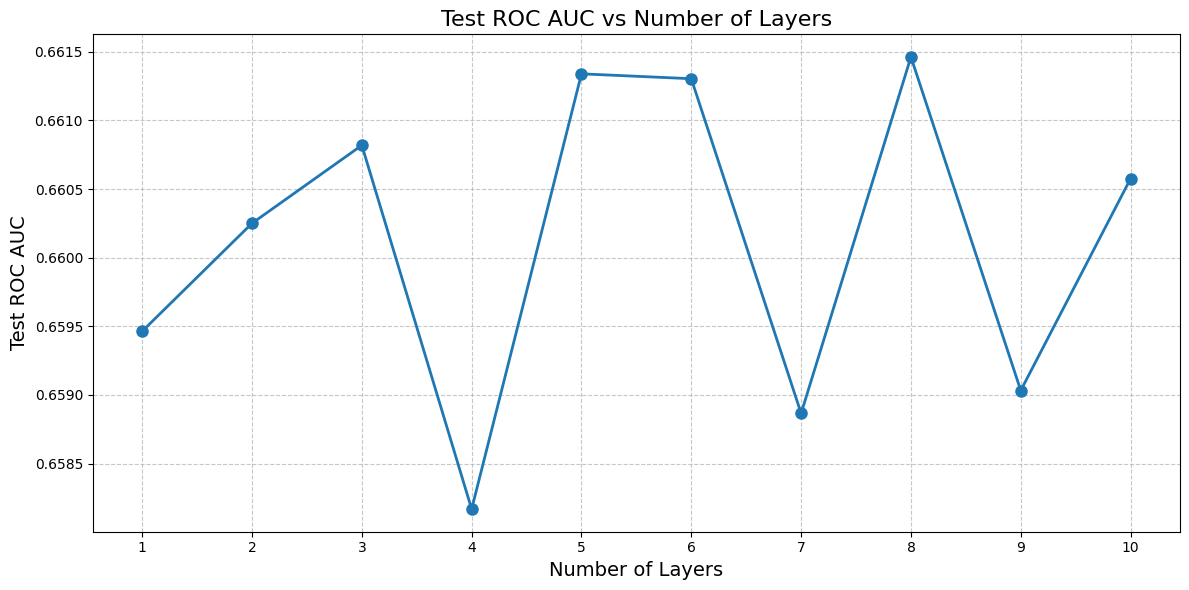

In [20]:
from src.models.viz import plot_roc_auc_vs_layers

# Iterate for each number of layers
layers_list = []
roc_auc_scores = []
for layers in range(1, 11):
    print(f"\nNumber of Layers = {layers}")

    # Define a new model, don't load in old weights.
    num_model = RDLModel(
        data=data,
        col_stats_dict=col_stats_dict,
        num_layers=layers,
        channels=128,
        out_channels=1,
        aggr="sum",
        norm="batch_norm",
    ).to(device)
    num_optimizer = torch.optim.Adam(num_model.parameters(), lr=0.005)
    num_state_dict = training_run(
        num_model,
        device,
        num_optimizer,
        task,
        loader_dict,
        val_table,
        loss_fn,
        entity_table,
        epochs=10,
    )
    num_model.load_state_dict(num_state_dict)

    # Evaluate on val and test set
    val_metrics = eval_model(num_model, loader_dict, "val", task, device, val_table)
    test_metrics = eval_model(num_model, loader_dict, "test", task, device, None)

    # Store the number of layers and corresponding test ROC AUC
    layers_list.append(layers)
    roc_auc_scores.append(test_metrics["roc_auc"])
plot_roc_auc_vs_layers(layers_list, roc_auc_scores)

### Challenge
Does this trend necessarily hold on larger and more diverse datasets? Depending on your compute availability, try out using different datasets, like `rel-amazon`, as well as across different types of tasks!

### What about different GNN layers?
Finally, let's explore the use of different GNN layers. In particular, let's explore the use of Graph Attention Networks, also known as GAT.

In GAT, for a singular node, different importance is assigned to messages coming from different nodes. In particular, the formulation takes inspiration from cognitive attention, focusing only on important parts of the input data.

To start, we first define our attention mechanism $a$. Then, for given nodes $u$ and $v$, at layer $l$, we we define the attention coefficients using a weight matrix $W^{l}$ and node embeddings $h_u$ and $h_v$ as follows:

$e_{v_u} := a(W^{l} h_{u}^{(l - 1)}, W^{l} h_{v}^{(l - 1)})$.

Then, we normalize all of the attention coefficients $e_{v, u}$ using softmax to obtain our attention weights $\alpha_{v, u}$:

$\alpha_{v, u} := \frac{\exp e_{v, u}}{\sum_{k \in N(v)} \exp e_{v, k}}$.

Finally, we use the attention weights in the final update for our embedding:

$h_{v}^{(l)} := \sigma( \sum_{u \in N(v)} \alpha_{v, u} W^{l} h_{u}^{(l - 1)})$.

Overall, the benefits of attention are that we are able to implicitly specify different importance values of neighbors. From a computational standpoint, attention is also storage and computationally efficient.


Let's now use GAT in our RDL pipeline. Note that this comes out of the box already for us with PyG, making our lives a lot easier.

In [21]:
# Define a new model, don't load in old weights.
from src.models.rdl.gat import RDLGATModel

gcn_model = RDLGATModel(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="sum",
    norm="batch_norm",
).to(device)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005)
gcn_state_dict = training_run(
    gcn_model,
    device,
    gcn_optimizer,
    task,
    loader_dict,
    val_table,
    loss_fn,
    entity_table,
    epochs=10,
)
gcn_model.load_state_dict(gcn_state_dict)

# Evaluate on val and test set
eval_model(gcn_model, loader_dict, "val", task, device, val_table)
eval_model(gcn_model, loader_dict, "test", task, device, None)

100%|██████████| 98/98 [00:14<00:00,  6.65it/s]


Epoch: 01, Train loss: 0.3092704020500183, Val metrics: {'average_precision': np.float64(0.931314485176838), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6141996754509245)}


100%|██████████| 98/98 [00:14<00:00,  6.75it/s]


Epoch: 02, Train loss: 0.30342929342746733, Val metrics: {'average_precision': np.float64(0.9331149311202773), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6242724808963903)}


100%|██████████| 98/98 [00:14<00:00,  6.74it/s]


Epoch: 03, Train loss: 0.300401547832489, Val metrics: {'average_precision': np.float64(0.9406272047041391), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6517649139422232)}


100%|██████████| 98/98 [00:14<00:00,  6.79it/s]


Epoch: 04, Train loss: 0.29793893871307375, Val metrics: {'average_precision': np.float64(0.940516241002927), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6494260105162599)}


100%|██████████| 98/98 [00:14<00:00,  6.75it/s]


Epoch: 05, Train loss: 0.2977857624053955, Val metrics: {'average_precision': np.float64(0.9419001927608364), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6557761545020828)}


100%|██████████| 98/98 [00:14<00:00,  6.67it/s]


Epoch: 06, Train loss: 0.29764677718162535, Val metrics: {'average_precision': np.float64(0.9404842902080781), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6481631435548112)}


100%|██████████| 98/98 [00:14<00:00,  6.73it/s]


Epoch: 07, Train loss: 0.29678841374874115, Val metrics: {'average_precision': np.float64(0.9418272280347302), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.655986957750963)}


100%|██████████| 98/98 [00:14<00:00,  6.79it/s]


Epoch: 08, Train loss: 0.2965826305580139, Val metrics: {'average_precision': np.float64(0.942478899658439), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6601548794191634)}


100%|██████████| 98/98 [00:14<00:00,  6.76it/s]


Epoch: 09, Train loss: 0.29613960445404053, Val metrics: {'average_precision': np.float64(0.942635300454244), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6588633051351153)}


100%|██████████| 98/98 [00:14<00:00,  6.78it/s]


Epoch: 10, Train loss: 0.29491244676589967, Val metrics: {'average_precision': np.float64(0.9424932122383862), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6589056929421895)}
Best val metrics: {'average_precision': np.float64(0.9422258012274802), 'accuracy': 0.9034991160479002, 'f1': np.float64(0.949303425917813), 'roc_auc': np.float64(0.6597603276108497)}
Best test metrics: {'average_precision': np.float64(0.9040323753027851), 'accuracy': 0.8505909380276232, 'f1': np.float64(0.9192641340113671), 'roc_auc': np.float64(0.6478599409673892)}


{'average_precision': np.float64(0.9040323753027851),
 'accuracy': 0.8505909380276232,
 'f1': np.float64(0.9192641340113671),
 'roc_auc': np.float64(0.6478599409673892)}

As we can see, we see no change from using GraphSAGE. This could perhaps be a consequence of the size of the dataset, consistent with other RDL pipelines -- even those with GraphSAGE but with different numbers of layers, for example -- but more exploration can be done.

### Challenge
Try performing all the above experiments with the GAT architecture instead? Does zero-shot/finetuning behavior differ? What about adding or subtracting layers? Definitely try it out!

## Conclusion

We hope you enjoyed going through this tutorial! Be sure to try out the challenges!